<a href="https://colab.research.google.com/github/gsvenky89/Assignemnt_2_ML/blob/master/CNN_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tqdm

In [0]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [0]:
import sys
sys.path.append("..")
sys.setrecursionlimit(3000)

In [4]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print("TensoreFlow Ver:",tf.__version__)
print("Keras Ver:",keras.__version__)
import keras.utils
from keras_tqdm import TQDMCallback
import cv2
from sklearn.metrics import accuracy_score

TensoreFlow Ver: 1.12.0
Keras Ver: 2.2.4


Using TensorFlow backend.


In [5]:
reset_tf_session() #clearing up any default graph

In [0]:
from keras.datasets import mnist
(x_train_i, y_train_i), (x_test_i, y_test_i) = mnist.load_data()
my_list = np.random.choice(x_train_i.shape[0],5000)
x_train = x_train_i[my_list,:]
y_train = y_train_i[my_list,]
del my_list
my_list = np.random.choice(x_test_i.shape[0],2000)
x_test = x_test_i[my_list,:]
y_test = y_test_i[my_list,]
del x_train_i,y_train_i,x_test_i,y_test_i,my_list

In [7]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (5000, 28, 28) (5000,)
Test samples: (2000, 28, 28) (2000,)


In [0]:
NUM_CLASSES = 10

In [9]:
# normalize inputs
x_train2t = x_train/255. - 0.5
x_test2t = x_test/255. - 0.5
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train[range(5000),], num_classes=NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test[range(2000),], num_classes=NUM_CLASSES)
print(y_train2.shape,y_test2.shape)

(5000, 10) (2000, 10)


In [0]:
#Converting the grey-scale image to RGB to suit the Input Layer of ResNet152
x_train2s = []
x_test2s = []
for i in range(x_train2t.shape[0]):
 x_train2s.append(np.stack((x_train2t[i,:,:],)*1,axis=-1))
x_train2 = np.array(x_train2s,dtype=np.uint8)
del x_train2t,x_train2s
for i in range(x_test2t.shape[0]):
 x_test2s.append(np.stack((x_test2t[i,:,:],)*1,axis=-1))
x_test2 = np.array(x_test2s,dtype=np.uint8)
del x_test2t,x_test2s

In [11]:
print(x_train2.shape,x_test2.shape)

(5000, 28, 28, 1) (2000, 28, 28, 1)


In [0]:
NUM_CLASSES = 10
mnist_classes = ["0", "1", "2", "3", "4", 
                   "5", "6", "7", "8", "9"]

X_train [shape (5000, 28, 28)] sample patch:
 [[  0  96 253 253 158]
 [  0 100 253 253  55]
 [  0 186 253 229  31]
 [  0 210 253 253 237]
 [  0 142 253 253 253]]
A closeup of a sample patch:


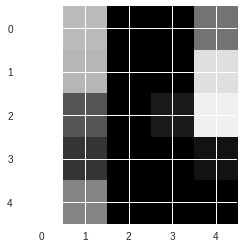

And the whole sample:


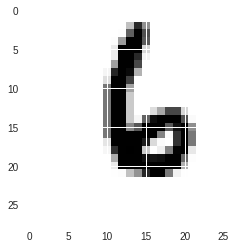

y_train [shape (5000,)] 10 samples:
 [4 6 6 7 3 0 5 1 2 8]


In [13]:
print("X_train [shape %s] sample patch:\n" % (str(x_train.shape)), x_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(x_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(x_train[2], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

In [0]:
# import necessary building blocks
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras import initializers
from keras.engine import Layer, InputSpec
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
     # CONV 1
    # first layer needs to define "input_shape"
    model.add(Conv2D(16, (3, 3), strides = (1, 1), padding="same", name = 'conv_layer_1', input_shape=(28, 28, 1)))   
    model.add(LeakyReLU(0.1))
    
    # CONV 2
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv_layer_2'))  
    model.add(LeakyReLU(0.1))
    
    # MaxPooling2D 1
    model.add(MaxPooling2D((2, 2), name='max_pool_1'))
    
    # Dropout
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    # CONV 3
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv_layer_3')) 
    model.add(LeakyReLU(0.1))
    
    # CONV 4
    model.add(Conv2D(64, (3, 3), strides = (1, 1), padding="same", name = 'conv_layer_4'))  
    model.add(LeakyReLU(0.1))
    
    # MaxPooling2D 1
    model.add(MaxPooling2D((2, 2), name='max_pool_2'))
    
    # Dropout
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    # Flatten
    model.add(Flatten())    
    
    # FC
    model.add(Dense(256, name='fc1'))
    model.add(Dropout(0.5, noise_shape=None, seed=0))
    
    # FC
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class    
    model.add(Activation("softmax"))  # output probabilities

    return model

In [16]:
# describe model
reset_tf_session() # clear default graph
model = make_model()
model.summary()
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy', # this is our cross-entropy
    optimizer=sgd,
    metrics=['accuracy']  # report accuracy during training
)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1 (Conv2D)        (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv_layer_3 (Conv2D)        (None, 14, 14, 32)        9248      
__________

In [17]:
model.fit(
    x_train2, 
    y_train2,
    batch_size=8, 
    epochs=10,
    validation_split= 0.3,
    #validation_data=(x_test2, y_test2),
    verbose = 1,shuffle=True
)

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 7s 2ms/step - loss: 2.3029 - acc: 0.0926 - val_loss: 2.3006 - val_acc: 0.0993
Epoch 2/10
3500/3500 [==============================] - 6s 2ms/step - loss: 2.3024 - acc: 0.1131 - val_loss: 2.3009 - val_acc: 0.0993
Epoch 3/10
3500/3500 [==============================] - 5s 2ms/step - loss: 2.3022 - acc: 0.1043 - val_loss: 2.2984 - val_acc: 0.1227
Epoch 4/10
3500/3500 [==============================] - 5s 2ms/step - loss: 2.3028 - acc: 0.0960 - val_loss: 2.2986 - val_acc: 0.1080
Epoch 5/10
3500/3500 [==============================] - 5s 2ms/step - loss: 2.3029 - acc: 0.1097 - val_loss: 2.2987 - val_acc: 0.1080
Epoch 6/10
3500/3500 [==============================] - 6s 2ms/step - loss: 2.3029 - acc: 0.0997 - val_loss: 2.2982 - val_acc: 0.1080
Epoch 7/10
3500/3500 [==============================] - 6s 2ms/step - loss: 2.3020 - acc: 0.1037 - val_loss: 2.2992 - val_acc: 0.0993
Epoch 8/10
350

In [18]:
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

Test accuracy: 0.12


In [0]:
model.save_weights("weights.h5")

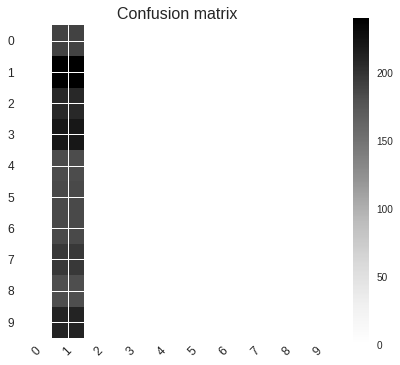

Test accuracy: 0.12
Test accuracy: 0.12


In [20]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), mnist_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), mnist_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

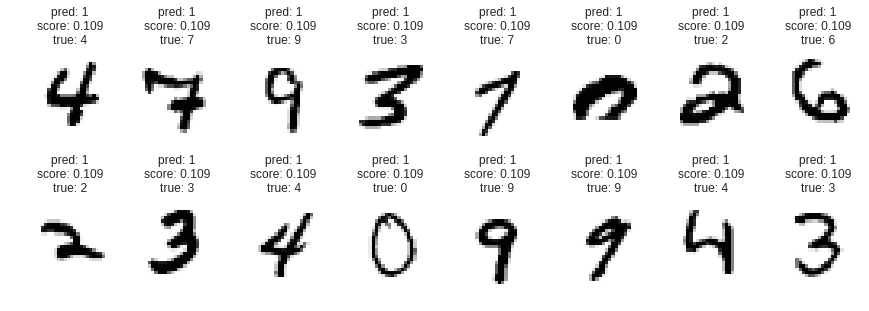

In [21]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = mnist_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = mnist_classes[y_test[random_index, ]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [0]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x - np.mean(x_train2)) / np.std(x_train2)

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 1))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value


In [0]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    stimuli2= [[]]
                    stimuli2 = stimuli[:,:,0]
                    ax.imshow(stimuli2)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()


conv_layer_1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


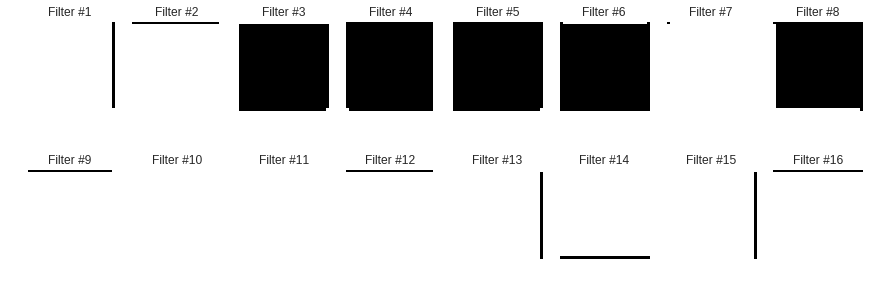

conv_layer_2


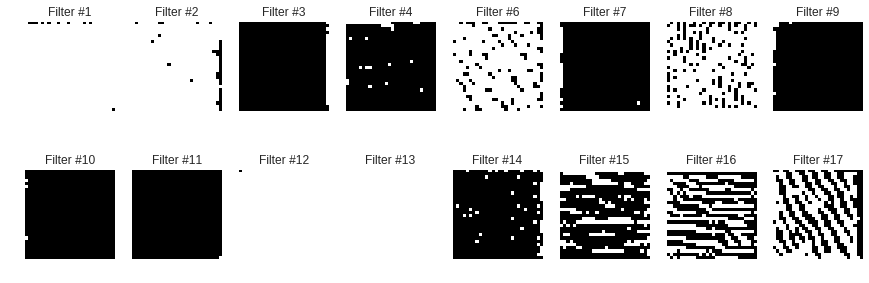

conv_layer_3


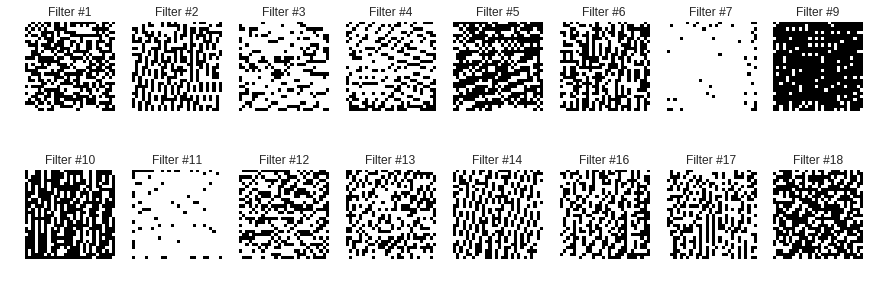

conv_layer_4


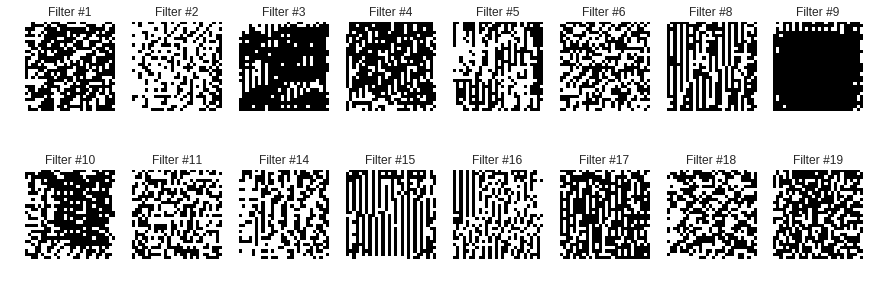

In [24]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    #if isinstance(layer, LeakyReLU):
        #prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

